# Load and setup

## Turn off warning

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Load basic library

In [2]:
import os
import re
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pch
from tqdm.autonotebook import tqdm

## Load geographic library

In [3]:
import rasterio
import rasterio.mask
import rasterio.warp
import geopandas as gpd
from osgeo import gdal
from rasterio.plot import show
from rasterio.merge import merge
from shapely.geometry import box

## Load machine learning library

In [4]:
import torch
import torch.nn as nn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import f_regression, SelectFpr

## Setup

In [5]:
RANDOM_STATE = 1000
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None)
# Remove the previous outputs
for i in ['Images for Deep Learning (Slope)', 'Images for Deep Learning (All)', 'Training set', 'Test set']:
    if os.path.isdir(i):
        shutil.rmtree(i)

# Define functions

## Read satellite imagery

In [6]:
# Read specific files from path
def readFiles(filePath, fileType):
    fileList = []
    for f in os.listdir(filePath):
        # Specify the file type
        if f.endswith(fileType):
            fileList.append(f)
    # Return a list of file names
    return fileList

In [7]:
# Extract satellite image info
def imgInfo(filePath, fileList):
    Bands, Shapes, Resolution, CRS, BoundingBoxes = [], [], [], [], []
    for i in tqdm(fileList, desc='Processing', unit=' img'):
        with rasterio.open(filePath + '/' + i) as img:
            # Extract features
            Bands.append(img.count)
            Shapes.append(img.shape)
            Resolution.append([img.res])
            CRS.append(img.crs.to_string())
            BoundingBoxes.append([*img.bounds])
    # Save image information as dataframe
    df_CRS = pd.DataFrame(CRS, columns = ['CRS'])
    df_Band = pd.DataFrame(Bands, columns = ['Bands'])
    df_Name = pd.DataFrame(fileList, columns = ['File_Name'])
    df_Shape = pd.DataFrame(Shapes, columns = ['Height', 'Width'])
    df_Resolution = pd.DataFrame(Resolution, columns = ['Resolution'])
    df_BoundingBox = pd.DataFrame(BoundingBoxes, columns = ['Bound_Left', 'Bound_Bottom', 'Bound_Right', 'Bound_Top'])
    return pd.concat([df_Name, df_Band, df_Shape, df_Resolution, df_CRS, df_BoundingBox], axis = 1)

## Reproject & Resampling

In [8]:
def reproject_image(src_fileList, src_pattern, dst_path, dst_crs):
    # Check if the new path exists
    if not os.path.isdir(dst_path):
        os.makedirs(dst_path)
    for i in tqdm(src_fileList, desc='Processing', unit=' img'):
        with rasterio.open(i) as src:
            # calculate the transform matrix
            transform, width, height = rasterio.warp.calculate_default_transform(
                src.crs,
                dst_crs,
                src.width,
                src.height,
                *src.bounds,
                resolution=(1, 1))
            kwargs = src.meta.copy()
            kwargs.update({'nodata': 0,
                           'width': width,
                           'height': height,
                           'crs': dst_crs,
                           'transform': transform})
            dst_name = 'Reprojected ' + ' '.join(re.findall(src_pattern, src.name))
            Reprojected_img = os.path.join(dst_path, dst_name)
            with rasterio.open(Reprojected_img, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    rasterio.warp.reproject(source=rasterio.band(src, i),
                                            src_crs=src.crs,
                                            src_transform=src.transform,
                                            destination=rasterio.band(dst, i),
                                            dst_crs=dst_crs,
                                            dst_transform=transform,
                                            resampling=rasterio.warp.Resampling.nearest)

## Overlapping detection

In [9]:
# Filter out the Lidar images that overlap with the paddock image
def Paddock_overlap_Lidar(df_Paddock, df_Lidar):
    overlapType, overlapList = [], []
    Lidar_list = df_Lidar.File_Name.tolist()
    for i in tqdm(df_Paddock.index, desc='Processing', unit=' img'):
        # Set boundaries
        L, B, R, T = df_Paddock.iloc[i]['Bound_Left':'Bound_Top']
        # Check if the paddock is fully in the Lidar image
        df_in = df_Lidar.query("Bound_Left <= @L & Bound_Bottom <= @B & Bound_Right >= @R & Bound_Top >= @T")
        if len(df_in) > 0:
            overlapList.append([df_in.File_Name.tolist()])
            overlapType.append('F')
        else:
            # Check if the paddock partially overlaps the Lidar image
            df_non_overlap = df_Lidar.query("Bound_Left > @R | Bound_Bottom > @T | Bound_Right < @L | Bound_Top < @B")
            non_overlap = df_non_overlap.File_Name.tolist()
            overlap = sorted(list(set(Lidar_list) - set(non_overlap)))
            overlapList.append([overlap])
            overlapType.append('P')
    # Save results as dataframe
    df_Name = df_Paddock[['File_Name']]
    df_Type = pd.DataFrame(overlapType, columns = ['Overlap_Type'])
    df_Overlap = pd.DataFrame(overlapList, columns = ['Paddock_Overlap_Lidar'])
    return pd.concat([df_Name, df_Type, df_Overlap], axis = 1)

## Copy overlapping Lidar images to new folder

In [10]:
# Copy overlapping Lidar images to new folder
def copyFiles(src_path, dst_path, fileList):
    # Check if the new path exists
    if not os.path.isdir(dst_path):
        os.makedirs(dst_path)
    # Copy the files in the file list to the new path
    for f in tqdm(fileList, desc='Processing', unit=' img'):
        full_src_path = os.path.join(src_path, f)
        shutil.copy(full_src_path, dst_path)

## Plot overlapping images

In [11]:
# Plot paddock and Lidar images to check overlap status
def plot_image(df_Paddock, df_Lidar):
    # Initialize the plot
    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111)
    # Plot all Lidar boundaries
    for i in df_Lidar.index:
        L, B, R, T = df_Lidar.iloc[i]['Bound_Left':'Bound_Top']
        rect = pch.Rectangle((L, B), width = R - L, height = T - B, edgecolor = 'blue', fill = False)
        ax.add_patch(rect)
        # Add the file name of each Lidar image
        text = df_Lidar.at[i,'File_Name'][-8:-4]
        ax.text(rect.get_center()[0], rect.get_center()[1], text,
                horizontalalignment = 'center', verticalalignment = 'center', color = 'blue')
    # Plot all paddock boundaries
    for i in df_Paddock.index:
        L, B, R, T = df_Paddock.iloc[i]['Bound_Left':'Bound_Top']
        rect = pch.Rectangle((L, B), width = R - L, height = T - B, edgecolor = 'red', fill = False)
        ax.add_patch(rect)
        # Add the file name of each Lidar image
        text = re.findall('Paddock \w+.tif', df_Paddock.at[i,'File_Name'])[0][8:-4]
        ax.text(rect.get_center()[0], rect.get_center()[1], text,
                horizontalalignment = 'center', verticalalignment = 'center', color = 'red')
    # Extract the overall boundaries of Lidar images
    xmin, xmax = df_Lidar.Bound_Left.min(), df_Lidar.Bound_Right.max()
    ymin, ymax = df_Lidar.Bound_Bottom.min(), df_Lidar.Bound_Top.max()
    # Set the range of the axes
    plt.xlim(xmin - 20, xmax + 20)
    plt.ylim(ymin - 20, ymax + 20)
    plt.show()

## Merge images

In [12]:
def merge_image(filePath, df_Overlap):
    for i in tqdm(df_Overlap.index, desc='Processing', unit=' img'):
        if df_Overlap.at[i,'Overlap_Type'] == 'P':
            overlapFile_list = df_Overlap.at[i,'Paddock_Overlap_Lidar']
            file_to_mosiac = []
            for f in overlapFile_list:
                img = rasterio.open(filePath + '/' + f)
                file_to_mosiac.append(img)
            mosaic, transform = merge(file_to_mosiac)
            kwargs = img.meta.copy()
            kwargs.update({'height': mosaic.shape[1],
                           'width': mosaic.shape[2],
                           'transform': transform})
            output_name = '+'.join(overlapFile_list)
            Mosaicked_img = os.path.join(filePath, output_name)
            with rasterio.open(Mosaicked_img, 'w', **kwargs) as output:
                output.write(mosaic)

## Calculate slope

In [13]:
def calculate_slope(src_fileList, src_pattern, dst_path):
    # Check if the new path exists
    if not os.path.isdir(dst_path):
        os.makedirs(dst_path)
    for i in tqdm(src_fileList, desc='Processing', unit=' img'):
        dst_name = 'Slope ' + '+'.join(re.findall(src_pattern, i))
        Slope_img = os.path.join(dst_path, dst_name)
        gdal.DEMProcessing(Slope_img, i, 'slope')

## Crop Lidar images

In [14]:
def crop_image(Paddock_path, Lidar_path, dst_path, df_Overlap):
    # Check if the new path exists
    if not os.path.isdir(dst_path):
        os.makedirs(dst_path)
    for i in tqdm(df_Overlap.index, desc='Processing', unit=' img'):
        with rasterio.open(Paddock_path + '/' + df_Overlap.at[i,'File_Name']) as Paddock_img:
            overlapLidar = '+'.join(df_Overlap.at[i,'Paddock_Overlap_Lidar'])
            slopeLidar = 'Slope ' + '+'.join(re.findall('\d+\.tif', overlapLidar))
            with rasterio.open(Lidar_path + '/' + slopeLidar) as Lidar_img:
                bbox = box(*Paddock_img.bounds)
                geo = gpd.GeoDataFrame({'geometry': [bbox]})
                mask, transform = rasterio.mask.mask(Lidar_img, geo.geometry, crop=True)
                kwargs = Lidar_img.meta.copy()
                kwargs.update({'height': mask.shape[1],
                               'width': mask.shape[2],
                               'transform': transform})
                output_name = 'Cropped ' + re.findall('\w+ \d{8}\w+ - Paddock \w+.tif[f]?', Paddock_img.name)[0]
                Cropped_img = os.path.join(dst_path, output_name)
                with rasterio.open(Cropped_img, 'w', **kwargs) as output:
                    output.write(mask)

## Trim, mask nodata, and save slope band

In [15]:
def save_slope_band(cropped_filePath, cropped_fileList, reprojected_filePath, dst_path):
    # Check if the new path exists
    if not os.path.isdir(dst_path):
        os.makedirs(dst_path)
    for f in tqdm(cropped_fileList, desc='Processing', unit=' img'):
        with rasterio.open(cropped_filePath + '/' + f) as slope_img:
            slope_band = slope_img.read()
            slope_band = slope_band[slope_band != -9999].reshape(slope_img.shape[0] - 1,
                                                                 slope_img.shape[1] - 1)
        paddock_name = re.findall('\w+ \d{8}\w+ - Paddock \w+.tif[f]?', f)[0]
        output_name = 'Prepared ' + paddock_name
        Prepared_img = os.path.join(dst_path, output_name)
        with gdal.Open(reprojected_filePath + '/Reprojected ' + paddock_name) as src:
            mask = src.GetRasterBand(1).ReadAsArray()
            slope_band[mask == 0] = 0
            driver = gdal.GetDriverByName('GTiff')
            output = driver.Create(Prepared_img,
                                   xsize=slope_band.shape[1],
                                   ysize=slope_band.shape[0],
                                   bands=5,
                                   eType=gdal.GDT_Float32)
            output.SetProjection(src.GetProjection())
            output.SetGeoTransform(src.GetGeoTransform())
            for i in range(4):
                band = output.GetRasterBand(i + 1)
                band.WriteArray(src.GetRasterBand(i + 1).ReadAsArray())
                band.SetNoDataValue(0)
                band.FlushCache()
            band_5 = output.GetRasterBand(5)
            band_5.WriteArray(slope_band)
            band_5.SetNoDataValue(0)
            band_5.FlushCache()

# Implementation step by step

## Lidar data info

In [16]:
filePath, fileType = 'Invermay/Invermay Lidar 890', '.tif'
df_Invermay_Lidar = imgInfo(filePath, readFiles(filePath, fileType))
df_Invermay_Lidar
# df_Invermay_Lidar.to_excel('df_Invermay_Lidar.xlsx', index=False)

Processing:   0%|          | 0/890 [00:00<?, ? img/s]

,File_Name,Bands,Height,Width,Resolution,CRS,Bound_Left,Bound_Bottom,Bound_Right,Bound_Top
0,DEM_CE16_2021_1000_2941.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1391200.0,4917120.0,1391680.0,4917840.0
1,DEM_CE17_2021_1000_2807.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1398880.0,4917840.0,1399360.0,4918560.0
2,DEM_CE17_2021_1000_2813.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1401760.0,4917840.0,1402240.0,4918560.0
3,DEM_CE17_2021_1000_2620.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1405120.0,4919280.0,1405600.0,4920000.0
4,DEM_CE16_2021_1000_3336.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1388800.0,4914240.0,1389280.0,4914960.0
...,...,...,...,...,...,...,...,...,...,...
885,DEM_CE17_2021_1000_2605.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1397920.0,4919280.0,1398400.0,4920000.0
886,DEM_CE16_2021_1000_2743.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1392160.0,4918560.0,1392640.0,4919280.0
887,DEM_CE16_2021_1000_3449.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1395040.0,4913520.0,1395520.0,4914240.0
888,DEM_CE17_2021_1000_3527.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1408480.0,4912800.0,1408960.0,4913520.0


## Paddock data info

In [17]:
filePath, fileType = 'Invermay/20201005-20201008 - Planet', ('.tif', '.tiff')
df_Invermay = imgInfo(filePath, readFiles(filePath, fileType))
df_Invermay
# df_Invermay.to_excel('df_Invermay.xlsx', index=False)

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

,File_Name,Bands,Height,Width,Resolution,CRS,Bound_Left,Bound_Bottom,Bound_Right,Bound_Top
0,Invermay 20201008_Planet_221357 - Paddock 215.tif,4,52,50,"(3.0, 3.0)",EPSG:32759,453885.0,4921398.0,454035.0,4921554.0
1,Invermay 20201008_Planet_221357 - Paddock 201.tif,4,44,38,"(3.0, 3.0)",EPSG:32759,453519.0,4921572.0,453633.0,4921704.0
2,Invermay 20201008_Planet_221357 - Paddock 200.tif,4,43,37,"(3.0, 3.0)",EPSG:32759,453486.0,4921500.0,453597.0,4921629.0
3,Invermay 20201008_Planet_221357 - Paddock 202.tif,4,56,69,"(3.0, 3.0)",EPSG:32759,453531.0,4921647.0,453738.0,4921815.0
4,Invermay 20201008_Planet_221357 - Paddock 216.tif,4,65,101,"(3.0, 3.0)",EPSG:32759,453849.0,4921545.0,454152.0,4921740.0
...,...,...,...,...,...,...,...,...,...,...
18,Invermay 20201008_Planet_221357 - Paddock 222.tif,4,63,65,"(3.0, 3.0)",EPSG:32759,454275.0,4921296.0,454470.0,4921485.0
19,Invermay 20201008_Planet_221357 - Paddock 226.tif,4,45,48,"(3.0, 3.0)",EPSG:32759,453729.0,4920900.0,453873.0,4921035.0
20,Invermay 20201008_Planet_221357 - Paddock 225.tif,4,63,99,"(3.0, 3.0)",EPSG:32759,453834.0,4920984.0,454131.0,4921173.0
21,Invermay 20201008_Planet_221357 - Paddock 224.tif,4,72,101,"(3.0, 3.0)",EPSG:32759,453936.0,4921074.0,454239.0,4921290.0


## Execute reproject

In [18]:
filePath = 'Invermay/20201005-20201008 - Planet'
fileList = df_Invermay.File_Name.to_list()
src_fileList = [filePath + '/' + i for i in fileList]
src_pattern = '\w+ \d{8}\w+ - Paddock \w+.tif[f]?'
dst_path, dst_crs = '1.Reprojected Paddock', 'EPSG:2193'
reproject_image(src_fileList, src_pattern, dst_path, dst_crs)

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

## Reprojected paddock info

In [19]:
filePath = '1.Reprojected Paddock'
fileList = os.listdir(filePath)
df_Reprojected_Invermay = imgInfo(filePath, fileList)
df_Reprojected_Invermay
# df_Reprojected_Invermay.to_excel('df_Reprojected_Invermay.xlsx', index=False)

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

,File_Name,Bands,Height,Width,Resolution,CRS,Bound_Left,Bound_Bottom,Bound_Right,Bound_Top
0,Reprojected Invermay 20201008_Planet_221357 - Paddock 226.tif,4,139,148,"(1.0, 1.0)",EPSG:2193,1.398484e+06,4.917795e+06,1.398632e+06,4.917934e+06
1,Reprojected Invermay 20201008_Planet_221357 - Paddock 225.tif,4,196,304,"(1.0, 1.0)",EPSG:2193,1.398585e+06,4.917882e+06,1.398889e+06,4.918078e+06
2,Reprojected Invermay 20201008_Planet_221357 - Paddock 217A.tif,4,148,286,"(1.0, 1.0)",EPSG:2193,1.398705e+06,4.918644e+06,1.398991e+06,4.918792e+06
3,Reprojected Invermay 20201008_Planet_221357 - Paddock 224.tif,4,226,310,"(1.0, 1.0)",EPSG:2193,1.398684e+06,4.917972e+06,1.398994e+06,4.918198e+06
4,Reprojected Invermay 20201008_Planet_221357 - Paddock 218.tif,4,82,193,"(1.0, 1.0)",EPSG:2193,1.398561e+06,4.918711e+06,1.398754e+06,4.918793e+06
...,...,...,...,...,...,...,...,...,...,...
18,Reprojected Invermay 20201008_Planet_221357 - Paddock 200.tif,4,133,115,"(1.0, 1.0)",EPSG:2193,1.398226e+06,4.918388e+06,1.398341e+06,4.918521e+06
19,Reprojected Invermay 20201008_Planet_221357 - Paddock 216.tif,4,205,310,"(1.0, 1.0)",EPSG:2193,1.398586e+06,4.918441e+06,1.398896e+06,4.918646e+06
20,Reprojected Invermay 20201008_Planet_221357 - Paddock 202.tif,4,175,211,"(1.0, 1.0)",EPSG:2193,1.398266e+06,4.918536e+06,1.398477e+06,4.918711e+06
21,Reprojected Invermay 20201008_Planet_221357 - Paddock 203.tif,4,145,112,"(1.0, 1.0)",EPSG:2193,1.398386e+06,4.918464e+06,1.398498e+06,4.918609e+06


## Overlapping list

In [20]:
df_Overlap = Paddock_overlap_Lidar(df_Reprojected_Invermay, df_Invermay_Lidar)
df_Overlap

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

,File_Name,Overlap_Type,Paddock_Overlap_Lidar
0,Reprojected Invermay 20201008_Planet_221357 - Paddock 226.tif,P,"[DEM_CE17_2021_1000_2806.tif, DEM_CE17_2021_1000_2906.tif]"
1,Reprojected Invermay 20201008_Planet_221357 - Paddock 225.tif,P,"[DEM_CE17_2021_1000_2806.tif, DEM_CE17_2021_1000_2807.tif]"
2,Reprojected Invermay 20201008_Planet_221357 - Paddock 217A.tif,P,"[DEM_CE17_2021_1000_2706.tif, DEM_CE17_2021_1000_2707.tif]"
3,Reprojected Invermay 20201008_Planet_221357 - Paddock 224.tif,P,"[DEM_CE17_2021_1000_2806.tif, DEM_CE17_2021_1000_2807.tif]"
4,Reprojected Invermay 20201008_Planet_221357 - Paddock 218.tif,F,[DEM_CE17_2021_1000_2706.tif]
...,...,...,...
18,Reprojected Invermay 20201008_Planet_221357 - Paddock 200.tif,F,[DEM_CE17_2021_1000_2805.tif]
19,Reprojected Invermay 20201008_Planet_221357 - Paddock 216.tif,P,"[DEM_CE17_2021_1000_2706.tif, DEM_CE17_2021_1000_2707.tif, DEM_CE17_2021_1000_2806.tif, DEM_CE17_2021_1000_2807.tif]"
20,Reprojected Invermay 20201008_Planet_221357 - Paddock 202.tif,P,"[DEM_CE17_2021_1000_2705.tif, DEM_CE17_2021_1000_2706.tif, DEM_CE17_2021_1000_2805.tif, DEM_CE17_2021_1000_2806.tif]"
21,Reprojected Invermay 20201008_Planet_221357 - Paddock 203.tif,P,"[DEM_CE17_2021_1000_2705.tif, DEM_CE17_2021_1000_2706.tif, DEM_CE17_2021_1000_2805.tif, DEM_CE17_2021_1000_2806.tif]"


## Copy overlapping Lidar images

In [21]:
src_path, dst_path = 'Invermay/Invermay Lidar 890', '2.Overlapping Lidar'
fileList = {item for sublist in df_Overlap.Paddock_Overlap_Lidar.tolist() for item in sublist}
copyFiles(src_path, dst_path, fileList)

Processing:   0%|          | 0/12 [00:00<?, ? img/s]

## Execute plotting

Processing:   0%|          | 0/12 [00:00<?, ? img/s]

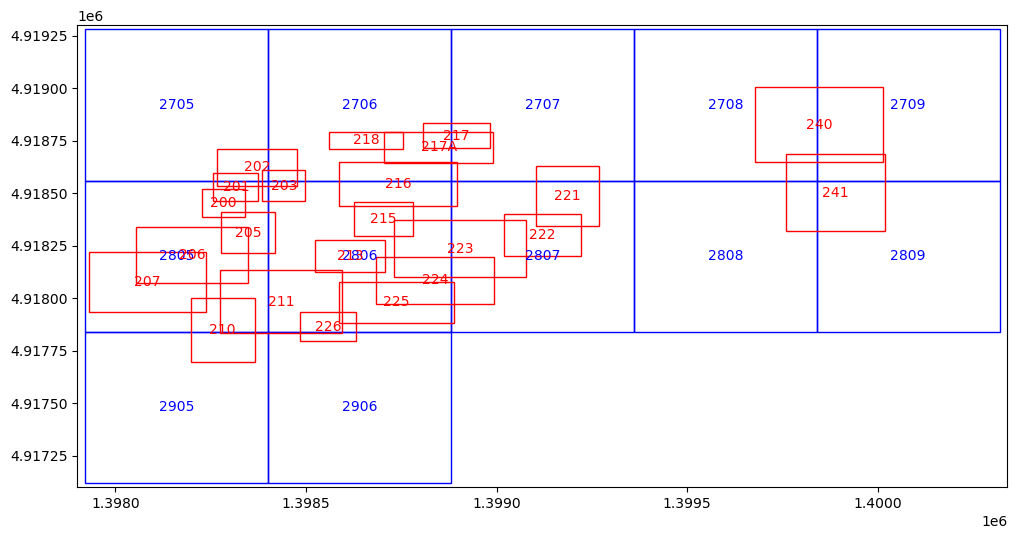

In [22]:
filePath = '2.Overlapping Lidar'
fileList = os.listdir(filePath)
df_overlap_Lidar = imgInfo(filePath, fileList)
plot_image(df_Reprojected_Invermay, df_overlap_Lidar)

## Execute merge

In [23]:
filePath = '2.Overlapping Lidar'
merge_image(filePath, df_Overlap)

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

## Calculate slope of overlapping Lidar images

In [24]:
filePath = '2.Overlapping Lidar'
fileList = os.listdir(filePath)
src_fileList = [filePath + '/' + i for i in fileList]
src_pattern = '\d+\.tif'
dst_path = '3.Slope Lidar'
calculate_slope(src_fileList, src_pattern, dst_path)

Processing:   0%|          | 0/24 [00:00<?, ? img/s]

## Crop paddock area from lidar slope images

In [25]:
Paddock_path, Lidar_path, dst_path = '1.Reprojected Paddock', '3.Slope Lidar', '4.Cropped Lidar'
crop_image(Paddock_path, Lidar_path, dst_path, df_Overlap)

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

## Cropped Lidar info

In [26]:
filePath = '4.Cropped Lidar'
fileList = os.listdir(filePath)
df_slope_Invermay = imgInfo(filePath, fileList)
df_slope_Invermay

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

,File_Name,Bands,Height,Width,Resolution,CRS,Bound_Left,Bound_Bottom,Bound_Right,Bound_Top
0,Cropped Invermay 20201008_Planet_221357 - Paddock 225.tif,1,197,305,"(1.0, 1.0)",EPSG:2193,1398585.0,4917882.0,1398890.0,4918079.0
1,Cropped Invermay 20201008_Planet_221357 - Paddock 218.tif,1,83,194,"(1.0, 1.0)",EPSG:2193,1398561.0,4918710.0,1398755.0,4918793.0
2,Cropped Invermay 20201008_Planet_221357 - Paddock 224.tif,1,227,311,"(1.0, 1.0)",EPSG:2193,1398684.0,4917972.0,1398995.0,4918199.0
3,Cropped Invermay 20201008_Planet_221357 - Paddock 226.tif,1,140,149,"(1.0, 1.0)",EPSG:2193,1398483.0,4917794.0,1398632.0,4917934.0
4,Cropped Invermay 20201008_Planet_221357 - Paddock 223.tif,1,272,347,"(1.0, 1.0)",EPSG:2193,1398731.0,4918100.0,1399078.0,4918372.0
...,...,...,...,...,...,...,...,...,...,...
18,Cropped Invermay 20201008_Planet_221357 - Paddock 203.tif,1,146,113,"(1.0, 1.0)",EPSG:2193,1398385.0,4918463.0,1398498.0,4918609.0
19,Cropped Invermay 20201008_Planet_221357 - Paddock 217.tif,1,122,176,"(1.0, 1.0)",EPSG:2193,1398806.0,4918713.0,1398982.0,4918835.0
20,Cropped Invermay 20201008_Planet_221357 - Paddock 201.tif,1,137,119,"(1.0, 1.0)",EPSG:2193,1398256.0,4918460.0,1398375.0,4918597.0
21,Cropped Invermay 20201008_Planet_221357 - Paddock 215.tif,1,161,155,"(1.0, 1.0)",EPSG:2193,1398626.0,4918296.0,1398781.0,4918457.0


## Execute trim and mask

In [27]:
cropped_filePath = '4.Cropped Lidar'
cropped_fileList = os.listdir(cropped_filePath)
reprojected_filePath = '1.Reprojected Paddock'
dst_path = '5.Prepared Paddock'
save_slope_band(cropped_filePath, cropped_fileList, reprojected_filePath, dst_path)

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

## Prepared paddock info

In [28]:
filePath = '5.Prepared Paddock'
fileList = os.listdir(filePath)
df_Prepared_Invermay = imgInfo(filePath, fileList)
df_Prepared_Invermay

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

,File_Name,Bands,Height,Width,Resolution,CRS,Bound_Left,Bound_Bottom,Bound_Right,Bound_Top
0,Prepared Invermay 20201008_Planet_221357 - Paddock 218.tif,5,82,193,"(1.0, 1.0)",EPSG:2193,1.398561e+06,4.918711e+06,1.398754e+06,4.918793e+06
1,Prepared Invermay 20201008_Planet_221357 - Paddock 224.tif,5,226,310,"(1.0, 1.0)",EPSG:2193,1.398684e+06,4.917972e+06,1.398994e+06,4.918198e+06
2,Prepared Invermay 20201008_Planet_221357 - Paddock 225.tif,5,196,304,"(1.0, 1.0)",EPSG:2193,1.398585e+06,4.917882e+06,1.398889e+06,4.918078e+06
3,Prepared Invermay 20201008_Planet_221357 - Paddock 226.tif,5,139,148,"(1.0, 1.0)",EPSG:2193,1.398484e+06,4.917795e+06,1.398632e+06,4.917934e+06
4,Prepared Invermay 20201008_Planet_221357 - Paddock 222.tif,5,196,202,"(1.0, 1.0)",EPSG:2193,1.399019e+06,4.918203e+06,1.399221e+06,4.918399e+06
...,...,...,...,...,...,...,...,...,...,...
18,Prepared Invermay 20201008_Planet_221357 - Paddock 202.tif,5,175,211,"(1.0, 1.0)",EPSG:2193,1.398266e+06,4.918536e+06,1.398477e+06,4.918711e+06
19,Prepared Invermay 20201008_Planet_221357 - Paddock 216.tif,5,205,310,"(1.0, 1.0)",EPSG:2193,1.398586e+06,4.918441e+06,1.398896e+06,4.918646e+06
20,Prepared Invermay 20201008_Planet_221357 - Paddock 200.tif,5,133,115,"(1.0, 1.0)",EPSG:2193,1.398226e+06,4.918388e+06,1.398341e+06,4.918521e+06
21,Prepared Invermay 20201008_Planet_221357 - Paddock 215.tif,5,160,154,"(1.0, 1.0)",EPSG:2193,1.398627e+06,4.918297e+06,1.398781e+06,4.918457e+06


# Implementation all Invermay images

In [29]:
# Remove the previous outputs and start again
for folder in filter(lambda x: re.findall('[12345]\.\w+', x), os.listdir()):
    shutil.rmtree(folder)
# Traverse all subfolders
for sub_folder in filter(lambda x: re.findall('\d{8}-\d{8} - \w+', x), os.listdir('Invermay')):
    # Generate Paddock dataframe
    filePath, fileType = 'Invermay/' + sub_folder, ('.tif', '.tiff')
    df_Invermay = imgInfo(filePath, readFiles(filePath, fileType))
    # Execute reproject
    src_fileList = [filePath + '/' + i for i in df_Invermay.File_Name.to_list()]
    src_pattern = '\w+ \d{8}\w+ - Paddock \w+.tif[f]?'
    reproject_image(src_fileList, src_pattern, '1.Reprojected Paddock', 'EPSG:2193')
    # Generate Reprojected paddock dataframe
    df_Reprojected_Invermay = imgInfo('1.Reprojected Paddock', os.listdir('1.Reprojected Paddock'))
    # Generate Overlapping dataframe
    df_Overlap = Paddock_overlap_Lidar(df_Reprojected_Invermay, df_Invermay_Lidar)
    # Copy overlapping Lidar images
    fileList = {item for sublist in df_Overlap.Paddock_Overlap_Lidar.tolist() for item in sublist}
    copyFiles('Invermay/Invermay Lidar 890', '2.Overlapping Lidar', fileList)
    # Execute merge
    merge_image('2.Overlapping Lidar', df_Overlap)
    # Calculate slope of overlapping Lidar images
    fileList = os.listdir('2.Overlapping Lidar')
    src_fileList = ['2.Overlapping Lidar' + '/' + i for i in fileList]
    calculate_slope(src_fileList, '\d+\.tif', '3.Slope Lidar')
    # Crop paddock area from lidar slope images
    crop_image('1.Reprojected Paddock', '3.Slope Lidar', '4.Cropped Lidar', df_Overlap)
    # Execute trim and mask
    cropped_fileList = os.listdir('4.Cropped Lidar')
    save_slope_band('4.Cropped Lidar', cropped_fileList, '1.Reprojected Paddock', '5.Prepared Paddock')
    for folder in filter(lambda x: re.findall('[1234]\.\w+', x), os.listdir()):
        shutil.rmtree(folder)
# Generate Prepared paddock dataframe
df_Prepared_Invermay = imgInfo('5.Prepared Paddock', os.listdir('5.Prepared Paddock'))
df_Prepared_Invermay

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/12 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/24 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/32 [00:00<?, ? img/s]

Processing:   0%|          | 0/32 [00:00<?, ? img/s]

Processing:   0%|          | 0/32 [00:00<?, ? img/s]

Processing:   0%|          | 0/32 [00:00<?, ? img/s]

Processing:   0%|          | 0/5 [00:00<?, ? img/s]

Processing:   0%|          | 0/32 [00:00<?, ? img/s]

Processing:   0%|          | 0/9 [00:00<?, ? img/s]

Processing:   0%|          | 0/32 [00:00<?, ? img/s]

Processing:   0%|          | 0/32 [00:00<?, ? img/s]

Processing:   0%|          | 0/11 [00:00<?, ? img/s]

Processing:   0%|          | 0/11 [00:00<?, ? img/s]

Processing:   0%|          | 0/11 [00:00<?, ? img/s]

Processing:   0%|          | 0/11 [00:00<?, ? img/s]

Processing:   0%|          | 0/11 [00:00<?, ? img/s]

Processing:   0%|          | 0/11 [00:00<?, ? img/s]

Processing:   0%|          | 0/16 [00:00<?, ? img/s]

Processing:   0%|          | 0/11 [00:00<?, ? img/s]

Processing:   0%|          | 0/11 [00:00<?, ? img/s]

Processing:   0%|          | 0/35 [00:00<?, ? img/s]

Processing:   0%|          | 0/35 [00:00<?, ? img/s]

Processing:   0%|          | 0/35 [00:00<?, ? img/s]

Processing:   0%|          | 0/35 [00:00<?, ? img/s]

Processing:   0%|          | 0/8 [00:00<?, ? img/s]

Processing:   0%|          | 0/35 [00:00<?, ? img/s]

Processing:   0%|          | 0/14 [00:00<?, ? img/s]

Processing:   0%|          | 0/35 [00:00<?, ? img/s]

Processing:   0%|          | 0/35 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/6 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/12 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/24 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/23 [00:00<?, ? img/s]

Processing:   0%|          | 0/128 [00:00<?, ? img/s]

,File_Name,Bands,Height,Width,Resolution,CRS,Bound_Left,Bound_Bottom,Bound_Right,Bound_Top
0,Prepared Invermay 20201008_Planet_221357 - Paddock 218.tif,5,82,193,"(1.0, 1.0)",EPSG:2193,1.398561e+06,4.918711e+06,1.398754e+06,4.918793e+06
1,Prepared Invermay 20201008_Planet_221357 - Paddock 224.tif,5,226,310,"(1.0, 1.0)",EPSG:2193,1.398684e+06,4.917972e+06,1.398994e+06,4.918198e+06
2,Prepared Invermay 20201012_Planet_215343 - Paddock 232.tif,5,361,370,"(1.0, 1.0)",EPSG:2193,1.399220e+06,4.917909e+06,1.399590e+06,4.918270e+06
3,Prepared Invermay 20201008_Planet_221357 - Paddock 225.tif,5,196,304,"(1.0, 1.0)",EPSG:2193,1.398585e+06,4.917882e+06,1.398889e+06,4.918078e+06
4,Prepared Invermay 20220818_CWOF - Paddock D5.tiff,5,103,163,"(1.0, 1.0)",EPSG:2193,1.396403e+06,4.918180e+06,1.396566e+06,4.918283e+06
...,...,...,...,...,...,...,...,...,...,...
123,Prepared Invermay 20201008_Planet_221357 - Paddock 201.tif,5,136,118,"(1.0, 1.0)",EPSG:2193,1.398257e+06,4.918461e+06,1.398375e+06,4.918597e+06
124,Prepared Invermay 20220819_CWOF - Paddock 13.tiff,5,106,115,"(1.0, 1.0)",EPSG:2193,1.396727e+06,4.917910e+06,1.396842e+06,4.918016e+06
125,Prepared Invermay 20220918_S2 - Paddock 84.tiff,5,162,162,"(1.0, 1.0)",EPSG:2193,1.398427e+06,4.918898e+06,1.398589e+06,4.919060e+06
126,Prepared Invermay 20201014_Planet_221210 - Paddock 245.tif,5,289,310,"(1.0, 1.0)",EPSG:2193,1.400277e+06,4.917634e+06,1.400587e+06,4.917923e+06


# Train linear model

## Calculate the mean of each band

In [30]:
def BandsMean(yPath, preparedImgPath):
    df_ground_truth = pd.read_csv(yPath)[['Processed_Paddock', 'CDAX']]
    # Calculate the mean of each band for each image
    bandsMeanList, Shapes = [], []
    for i in tqdm(df_ground_truth.Processed_Paddock, desc='Processing', unit=' img'):
        with rasterio.open(preparedImgPath + '/' + i) as img:
            bands = img.read().reshape(5, -1)
            bands[bands == 0] = np.nan
            bandsMean = np.nanmean(bands, axis = 1)
            bandsMeanList.append(bandsMean)
            Shapes.append(img.shape)
    # Save as data frame
    df_Shape = pd.DataFrame(Shapes, columns = ['Height', 'Width'])
    df_bandsMean = pd.DataFrame(bandsMeanList, columns = ['Blu', 'Gre', 'Red', 'Nir', 'Slo'])
    return pd.concat([df_ground_truth, df_Shape, df_bandsMean], axis = 1)

In [31]:
yPath = 'Invermay/Y - Invermay Planet.csv'
preparedImgPath = '5.Prepared Paddock'
df_ground_truth = BandsMean(yPath, preparedImgPath)
df_ground_truth

Processing:   0%|          | 0/94 [00:00<?, ? img/s]

,Processed_Paddock,CDAX,Height,Width,Blu,Gre,Red,Nir,Slo
0,Prepared Invermay 20201008_Planet_221357 - Paddock 200.tif,2612,133,115,349.783264,619.396301,615.110352,3914.101562,5.640727
1,Prepared Invermay 20201008_Planet_221357 - Paddock 201.tif,3290,136,118,268.179169,515.858887,486.923553,4371.109863,5.960751
2,Prepared Invermay 20201008_Planet_221357 - Paddock 202.tif,2799,175,211,353.986206,632.187256,623.157043,4387.208984,10.791287
3,Prepared Invermay 20201008_Planet_221357 - Paddock 203.tif,2818,145,112,291.084076,549.331421,506.285767,4924.514648,11.793829
4,Prepared Invermay 20201008_Planet_221357 - Paddock 205.tif,2667,193,142,291.784851,539.562805,518.533203,4482.874023,10.539539
...,...,...,...,...,...,...,...,...,...
89,Prepared Invermay 20220819_CWOF - Paddock D7.tiff,1582,109,145,420.009338,793.481995,557.932922,4728.696777,1.322564
90,Prepared Invermay 20220818_CWOF - Paddock D9.tiff,1534,97,142,385.515900,764.220886,542.403809,3938.517822,0.722708
91,Prepared Invermay 20220819_CWOF - Paddock D9.tiff,1534,97,142,443.926849,840.626770,583.231079,4848.030762,0.722708
92,Prepared Invermay 20220818_CWOF - Paddock D11.tiff,1540,94,145,382.927338,719.131836,554.255859,3784.996094,0.707130


## Fit linear regression model

In [32]:
def linear_regression(X_train, y_train, X_test, y_test):
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print(f'Model Coefficients: {reg.coef_}\nModel Intercept: {reg.intercept_}')
    print(f'MAELoss on Test set: {mean_absolute_error(y_test, y_pred)}\nR2 Score on Test set: {r2_score(y_test, y_pred)}')

In [33]:
# Select all features: Blu, Gre, Red, Nir, Slo
X, y = df_ground_truth.loc[:, 'Blu':'Slo'], df_ground_truth['CDAX']
# Random split training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RANDOM_STATE)
# Fit the linear model
linear_regression(X_train, y_train, X_test, y_test)

Model Coefficients: [  1.209478    -6.5164657    2.4926572    0.42355636 -15.163994  ]
Model Intercept: 2997.162353515625
MAELoss on Test set: 202.05360149515087
R2 Score on Test set: 0.5390036573188164


In [34]:
F, p = f_regression(X, y)
print(f'Blu: {p[0]:.8f}, Gre: {p[1]:.8f}, Red: {p[2]:.8f}, Nir: {p[3]:.8f}, Slo: {p[4]:.8f}')

Blu: 0.02573875, Gre: 0.00000005, Red: 0.89463816, Nir: 0.28199958, Slo: 0.00000003


In [35]:
# Select the features which p-value < 0.05
selector = SelectFpr(f_regression, alpha = 0.05)
X_new = selector.fit_transform(X, y)
# Random split training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state = RANDOM_STATE)
# Fit the linear model again
linear_regression(X_train, y_train, X_test, y_test)

Model Coefficients: [ 5.6452994 -7.0210137 -4.7066145]
Model Intercept: 4869.251953125
MAELoss on Test set: 184.23723733836206
R2 Score on Test set: 0.7002275291654969


# Prepare images for deep learning

## Prepare Invermay images

In [36]:
# Cope Invermay images for deep learning
copyFiles('5.Prepared Paddock', 'Images for Deep Learning (Slope)', df_ground_truth.Processed_Paddock.to_list())
copyFiles('5.Prepared Paddock', 'Images for Deep Learning (All)', df_ground_truth.Processed_Paddock.to_list())
# Remove the previous outputs
for folder in filter(lambda x: re.findall('[12345]\.\w+', x), os.listdir()):
    shutil.rmtree(folder)

Processing:   0%|          | 0/94 [00:00<?, ? img/s]

Processing:   0%|          | 0/94 [00:00<?, ? img/s]

## Prepare BLYP images

In [37]:
filePath, fileType = 'BLYP/BLYP Lidar 5527', '.tif'
df_BLYP_Lidar = imgInfo(filePath, readFiles(filePath, fileType))
df_BLYP_Lidar

Processing:   0%|          | 0/5527 [00:00<?, ? img/s]

,File_Name,Bands,Height,Width,Resolution,CRS,Bound_Left,Bound_Bottom,Bound_Right,Bound_Top
0,DEM_BK30_2021_1000_0321.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1717600.0,5619840.0,1718080.0,5620560.0
1,DEM_BJ29_2021_1000_1807.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1686880.0,5645040.0,1687360.0,5645760.0
2,DEM_BJ30_2021_1000_3933.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1723360.0,5629920.0,1723840.0,5630640.0
3,DEM_BJ30_2021_1000_1842.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1727680.0,5645040.0,1728160.0,5645760.0
4,DEM_BK30_2021_1000_0447.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1730080.0,5619120.0,1730560.0,5619840.0
...,...,...,...,...,...,...,...,...,...,...
5522,DEM_BJ30_2021_1000_4937.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1725280.0,5622720.0,1725760.0,5623440.0
5523,DEM_BK30_2021_1000_1740.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1726720.0,5609760.0,1727200.0,5610480.0
5524,DEM_BJ30_2021_1000_4923.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1718560.0,5622720.0,1719040.0,5623440.0
5525,DEM_BK30_2021_1000_1026.tif,1,720,480,"(1.0, 1.0)",EPSG:2193,1720000.0,5614800.0,1720480.0,5615520.0


In [38]:
# Traverse all subfolders
for sub_folder in filter(lambda x: re.findall('\d{8}-\d{8} - \w+', x), os.listdir('BLYP')):
    # Generate Paddock dataframe
    filePath, fileType = 'BLYP/' + sub_folder, ('tiff')
    df_BLYP = imgInfo(filePath, readFiles(filePath, fileType))
    # Execute reproject
    src_fileList = [filePath + '/' + i for i in df_BLYP.File_Name.to_list()]
    src_pattern = '\w+ \d{8}\w+ - Paddock \w+.tiff'
    reproject_image(src_fileList, src_pattern, '1.Reprojected Paddock', 'EPSG:2193')
    # Generate Reprojected paddock dataframe
    df_Reprojected_BLYP = imgInfo('1.Reprojected Paddock', os.listdir('1.Reprojected Paddock'))
    # Generate Overlapping dataframe
    df_Overlap = Paddock_overlap_Lidar(df_Reprojected_BLYP, df_BLYP_Lidar)
    # Copy overlapping Lidar images
    fileList = {item for sublist in df_Overlap.Paddock_Overlap_Lidar.tolist() for item in sublist}
    copyFiles('BLYP/BLYP Lidar 5527', '2.Overlapping Lidar', fileList)
    # Execute merge
    merge_image('2.Overlapping Lidar', df_Overlap)
    # Calculate slope of overlapping Lidar images
    fileList = os.listdir('2.Overlapping Lidar')
    src_fileList = ['2.Overlapping Lidar' + '/' + i for i in fileList]
    calculate_slope(src_fileList, '\d+.tif', '3.Slope Lidar')
    # Crop paddock area from lidar slope images
    crop_image('1.Reprojected Paddock', '3.Slope Lidar', '4.Cropped Lidar', df_Overlap)
    # Execute trim and mask
    cropped_fileList = os.listdir('4.Cropped Lidar')
    save_slope_band('4.Cropped Lidar', cropped_fileList, '1.Reprojected Paddock', '5.Prepared Paddock')
    for folder in filter(lambda x: re.findall('[1234]\.\w+', x), os.listdir()):
        shutil.rmtree(folder)
# Generate Prepared paddock dataframe
df_Prepared_BLYP = imgInfo('5.Prepared Paddock', os.listdir('5.Prepared Paddock'))
df_Prepared_BLYP

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/8 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/72 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/8 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/8 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/51 [00:00<?, ? img/s]

Processing:   0%|          | 0/51 [00:00<?, ? img/s]

Processing:   0%|          | 0/51 [00:00<?, ? img/s]

Processing:   0%|          | 0/51 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/51 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/51 [00:00<?, ? img/s]

Processing:   0%|          | 0/51 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/8 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/8 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/18 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/17 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/8 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/4 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/7 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/36 [00:00<?, ? img/s]

Processing:   0%|          | 0/892 [00:00<?, ? img/s]

,File_Name,Bands,Height,Width,Resolution,CRS,Bound_Left,Bound_Bottom,Bound_Right,Bound_Top
0,Prepared BLYP 20221228_CWOF - Paddock 30.tiff,5,54,219,"(1.0, 1.0)",EPSG:2193,1.698355e+06,5.624060e+06,1.698574e+06,5.624114e+06
1,Prepared BLYP 20221031_CWOF - Paddock 36.tiff,5,57,222,"(1.0, 1.0)",EPSG:2193,1.698348e+06,5.623836e+06,1.698570e+06,5.623893e+06
2,Prepared BLYP 20230228_CWOF - Paddock 34.tiff,5,54,222,"(1.0, 1.0)",EPSG:2193,1.698352e+06,5.623909e+06,1.698574e+06,5.623963e+06
3,Prepared BLYP 20230123_CWOF - Paddock 20.tiff,5,69,153,"(1.0, 1.0)",EPSG:2193,1.698298e+06,5.624414e+06,1.698451e+06,5.624483e+06
4,Prepared BLYP 20221003_CWOF - Paddock 21.tiff,5,66,135,"(1.0, 1.0)",EPSG:2193,1.698448e+06,5.624413e+06,1.698583e+06,5.624479e+06
...,...,...,...,...,...,...,...,...,...,...
887,Prepared BLYP 20230403_CWOF - Paddock 30.tiff,5,54,219,"(1.0, 1.0)",EPSG:2193,1.698355e+06,5.624060e+06,1.698574e+06,5.624114e+06
888,Prepared BLYP 20230415_CWOF - Paddock 12.tiff,5,54,198,"(1.0, 1.0)",EPSG:2193,1.698142e+06,5.624142e+06,1.698340e+06,5.624196e+06
889,Prepared BLYP 20221016_CWOF - Paddock 40.tiff,5,54,222,"(1.0, 1.0)",EPSG:2193,1.698350e+06,5.623679e+06,1.698572e+06,5.623733e+06
890,Prepared BLYP 20220925_CWOF - Paddock 39.tiff,5,51,219,"(1.0, 1.0)",EPSG:2193,1.698351e+06,5.623718e+06,1.698570e+06,5.623769e+06


In [39]:
# Cope BLYP images for deep learning
copyFiles('5.Prepared Paddock', 'Images for Deep Learning (All)', df_Prepared_BLYP.File_Name.to_list())
# Remove the previous outputs
for folder in filter(lambda x: re.findall('[12345]\.\w+', x), os.listdir()):
    shutil.rmtree(folder)

Processing:   0%|          | 0/892 [00:00<?, ? img/s]

## Prepare MRWH images

In [40]:
# filePath, fileType = 'MRWH/MRWH Lidar 1037', '.tif'
# df_MRWH_Lidar = imgInfo(filePath, readFiles(filePath, fileType))
# df_MRWH_Lidar

In [41]:
# # Traverse all subfolders
# for sub_folder in filter(lambda x: re.findall('\d{8}-\d{8} - \w+', x), os.listdir('MRWH')):
#     # Generate Paddock dataframe
#     filePath, fileType = 'MRWH/' + sub_folder, ('tiff')
#     df_MRWH = imgInfo(filePath, readFiles(filePath, fileType))
#     # Execute reproject
#     src_fileList = [filePath + '/' + i for i in df_MRWH.File_Name.to_list()]
#     src_pattern = '\w+ \d{8}\w+ - Paddock \w+.tiff'
#     reproject_image(src_fileList, src_pattern, '1.Reprojected Paddock', 'EPSG:2193')
#     # Generate Reprojected paddock dataframe
#     df_Reprojected_MRWH = imgInfo('1.Reprojected Paddock', os.listdir('1.Reprojected Paddock'))
#     # Generate Overlapping dataframe
#     df_Overlap = Paddock_overlap_Lidar(df_Reprojected_MRWH, df_MRWH_Lidar)
#     # Copy overlapping Lidar images
#     fileList = {item for sublist in df_Overlap.Paddock_Overlap_Lidar.tolist() for item in sublist}
#     copyFiles('MRWH/MRWH Lidar 1037', '2.Overlapping Lidar', fileList)
#     # Execute merge
#     merge_image('2.Overlapping Lidar', df_Overlap)
#     # Calculate slope of overlapping Lidar images
#     fileList = os.listdir('2.Overlapping Lidar')
#     src_fileList = ['2.Overlapping Lidar' + '/' + i for i in fileList]
#     calculate_slope(src_fileList, '\d+.tif', '3.Slope Lidar')
#     # Crop paddock area from lidar slope images
#     crop_image('1.Reprojected Paddock', '3.Slope Lidar', '4.Cropped Lidar', df_Overlap)
#     # Execute trim and mask
#     cropped_fileList = os.listdir('4.Cropped Lidar')
#     save_slope_band('4.Cropped Lidar', cropped_fileList, '1.Reprojected Paddock', '5.Prepared Paddock')
#     for folder in filter(lambda x: re.findall('[1234]\.\w+', x), os.listdir()):
#         shutil.rmtree(folder)
# # Generate Prepared paddock dataframe
# df_Prepared_MRWH = imgInfo('5.Prepared Paddock', os.listdir('5.Prepared Paddock'))
# df_Prepared_MRWH

In [42]:
# # Cope MRWH images for deep learning
# copyFiles('5.Prepared Paddock', 'Images for Deep Learning (All)', df_Prepared_MRWH.File_Name.to_list())
# # Remove the previous outputs
# for folder in filter(lambda x: re.findall('[12345]\.\w+', x), os.listdir()):
#     shutil.rmtree(folder)

# Train deep learning model

## Slope farm only

In [43]:
def read_ground_truth(yPath, preparedImgPath):
    df_ground_truth = pd.read_csv(yPath)[['Processed_Paddock', 'CDAX']]
    Shapes = []
    for i in tqdm(df_ground_truth.Processed_Paddock, desc='Processing', unit=' img'):
        with rasterio.open(preparedImgPath + '/' + i) as img:
            Shapes.append(img.shape)
    # Save as data frame
    df_Shape = pd.DataFrame(Shapes, columns = ['Height', 'Width'])
    return pd.concat([df_ground_truth, df_Shape], axis = 1)

In [44]:
def padding_img(df_train_test, img_path, H, W):
    data = []
    for i in tqdm(df_train_test.index, desc = 'Processing', unit = ' img'):
        with rasterio.open(img_path + '/' + df_train_test.at[i, 'Processed_Paddock']) as img:
            bands = torch.from_numpy(img.read())
            L = int((W - bands.shape[2]) / 2)
            R = W - L - bands.shape[2]
            T = int((H - bands.shape[1]) / 2)
            B = H - T - bands.shape[1]
            pad = nn.ZeroPad2d(padding = (L, R, T, B))
            data.append((pad(bands), df_train_test.at[i, 'CDAX'].astype(float)))
    return data

In [45]:
# Read ground truth file
df_ground_truth = read_ground_truth('Invermay/Y - Invermay Planet.csv', 'Images for Deep Learning (Slope)')
# Random split training set and test set
df_train = df_ground_truth.sample(frac = 0.7, random_state = RANDOM_STATE)
df_test = df_ground_truth.drop(df_train.index)
# Copy Prepared Paddock images to training and test folders
copyFiles('Images for Deep Learning (Slope)', 'Training set', df_train.Processed_Paddock.to_list())
copyFiles('Images for Deep Learning (Slope)', 'Test set', df_test.Processed_Paddock.to_list())

Processing:   0%|          | 0/94 [00:00<?, ? img/s]

Processing:   0%|          | 0/66 [00:00<?, ? img/s]

Processing:   0%|          | 0/28 [00:00<?, ? img/s]

In [46]:
H = (df_ground_truth.Height.max() // 100 + 1) * 100
W = (df_ground_truth.Width.max() // 100 + 1) * 100
train_set = padding_img(df_train, 'Training set', H, W)
test_set = padding_img(df_test, 'Test set', H, W)

Processing:   0%|          | 0/66 [00:00<?, ? img/s]

Processing:   0%|          | 0/28 [00:00<?, ? img/s]

In [47]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [48]:
class CNN(nn.Module):
    def __init__(self, input_size, batch_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = input_size, out_channels = batch_size * 4, kernel_size = 3, stride = 1),
            nn.BatchNorm2d(num_features = batch_size * 4),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = batch_size * 4, out_channels = batch_size * 16, kernel_size = 3, stride = 1),
            nn.BatchNorm2d(num_features = batch_size * 16),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = batch_size * 16, out_channels = batch_size * 64, kernel_size = 3, stride = 1),
            nn.BatchNorm2d(num_features = batch_size * 64),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc = nn.Sequential(
            nn.Linear(in_features = 48 * 48 * batch_size * 64, out_features = 3 * 3 * batch_size * 4),
            nn.ReLU(),
            nn.Linear(in_features = 3 * 3 * batch_size * 4, out_features = 1)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [49]:
# Initialize the model
input_size = 5
batch_size = 8
model = CNN(input_size, batch_size).to(device)

# Set random seed for reproducible results
torch.manual_seed(RANDOM_STATE)

# Define loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# Number of parameters
parameters = [p.numel() for p in model.parameters() if p.requires_grad]
print(f'Total number of parameters: {sum(parameters)}')

Total number of parameters: 340369345


In [50]:
def train(dataloader, model, loss_fn, optimizer):
    loss_list, pred_list, targ_list = [], [], []
    model.train()
    for batch_x, batch_y in dataloader:
        pred = model(batch_x).reshape(-1)
        pred_list.append(pred)
        
        targ_list.append(batch_y)
        
        loss = loss_fn(pred, batch_y)
        loss_list.append(loss.item())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return np.mean(loss_list), pred_list, targ_list

In [51]:
def test(dataloader, model, loss_fn):
    loss_list, pred_list, targ_list = [], [], []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            pred = model(batch_x).reshape(-1)
            pred_list.append(pred)
            
            targ_list.append(batch_y)
            
            loss = loss_fn(pred, batch_y)
            loss_list.append(loss.item())
            
    return np.mean(loss_list), pred_list, targ_list

In [52]:
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True, drop_last = True)

In [53]:
epochs = 50
min_loss = np.inf
epoch_train_loss = []
epoch_test_loss = []

start = time.time()
for epoch in range(epochs):
    train_loss, train_pred, train_targ = train(train_loader, model, loss_fn, optimizer)
    epoch_train_loss.append(train_loss)

    test_loss, test_pred, test_targ = test(test_loader, model, loss_fn)
    epoch_test_loss.append(test_loss)
    
    if test_loss < min_loss:
        min_loss = test_loss
        best_pred = test_pred
        best_targ = test_targ
    
    print(f'Epoch [{epoch+1:<3}/{epochs}]   Train Loss: {train_loss:.8f}   Test Loss: {test_loss:.8f}')
print(f'{"-"*60}\nDuration: {time.time() - start:.4f} seconds')
print(f'{"-"*60}\nBest MAELoss on Train set: {min(epoch_train_loss)}\nBest MAELoss on Test set: {min(epoch_test_loss)}\nBest R2 Score on Test set: {r2_score(best_targ, best_pred)}')

Epoch [1  /50]   Train Loss: 891.95761874   Test Loss: 429.86583964
Epoch [2  /50]   Train Loss: 464.79948044   Test Loss: 500.35061646
Epoch [3  /50]   Train Loss: 406.07133865   Test Loss: 541.34456889
Epoch [4  /50]   Train Loss: 343.60298920   Test Loss: 686.53265381
Epoch [5  /50]   Train Loss: 509.97517490   Test Loss: 448.53079224
Epoch [6  /50]   Train Loss: 288.57153511   Test Loss: 513.20526123
Epoch [7  /50]   Train Loss: 286.73537064   Test Loss: 440.96034241
Epoch [8  /50]   Train Loss: 286.23634720   Test Loss: 375.90116882
Epoch [9  /50]   Train Loss: 224.65761757   Test Loss: 506.05392965
Epoch [10 /50]   Train Loss: 275.72891617   Test Loss: 392.25013733
Epoch [11 /50]   Train Loss: 168.93226624   Test Loss: 330.77667745
Epoch [12 /50]   Train Loss: 216.73695755   Test Loss: 478.49106344
Epoch [13 /50]   Train Loss: 232.25213051   Test Loss: 437.81553141
Epoch [14 /50]   Train Loss: 204.40500832   Test Loss: 414.37956746
Epoch [15 /50]   Train Loss: 209.20998383   Test

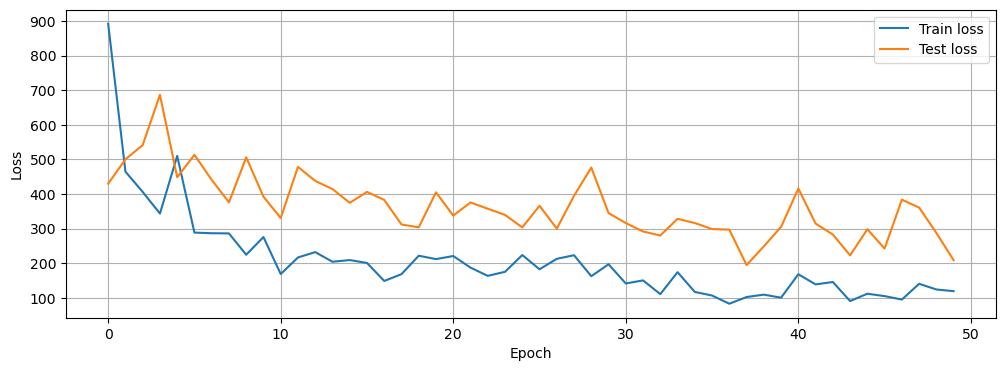

In [54]:
plt.figure(figsize = (12, 4))
plt.plot(epoch_train_loss, label = 'Train loss')
plt.plot(epoch_test_loss, label = 'Test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [55]:
df_pred_targ = pd.DataFrame(columns = ['Best prediction', 'Target'])
for i in range(len(best_pred)):
    df_new = pd.DataFrame({'Best prediction': best_pred[i], 'Target': best_targ[i]})
    df_pred_targ = pd.concat([df_pred_targ, df_new], ignore_index = True)
df_pred_targ['Abs difference'] = abs(df_pred_targ['Best prediction'] - df_pred_targ['Target'])
df_pred_targ['Difference %'] = (df_pred_targ['Abs difference'] / df_pred_targ['Target'])
avg_diff = df_pred_targ['Difference %'].mean()
df_pred_targ['Difference %'] = df_pred_targ['Difference %'].map('{:.2%}'.format)
df_pred_targ

,Best prediction,Target,Abs difference,Difference %
0,2394.783691,2429.0,34.216309,1.41%
1,2719.197021,2517.0,202.197021,8.03%
2,1553.489258,1316.0,237.489258,18.05%
3,1970.856689,2176.0,205.143311,9.43%
4,1636.336914,1459.0,177.336914,12.15%
...,...,...,...,...
19,2115.066406,2187.0,71.933594,3.29%
20,1717.577881,1626.0,91.577881,5.63%
21,2018.162109,1785.0,233.162109,13.06%
22,1466.617676,1534.0,67.382324,4.39%


In [56]:
print(f'Average difference: {avg_diff:.2%}')

Average difference: 8.89%


## Mix slopes and flats

In [57]:
# Remove the previous outputs
for i in ['Training set', 'Test set']:
    if os.path.isdir(i):
        shutil.rmtree(i)

In [58]:
# Read ground truth file
df_ground_truth = read_ground_truth('Y.csv', 'Images for Deep Learning (All)')
# Random split training set and test set
df_train = df_ground_truth.sample(frac = 0.7, random_state = RANDOM_STATE)
df_test = df_ground_truth.drop(df_train.index)
# Copy Prepared Paddock images to training and test folders
copyFiles('Images for Deep Learning (All)', 'Training set', df_train.Processed_Paddock.to_list())
copyFiles('Images for Deep Learning (All)', 'Test set', df_test.Processed_Paddock.to_list())

Processing:   0%|          | 0/986 [00:00<?, ? img/s]

Processing:   0%|          | 0/690 [00:00<?, ? img/s]

Processing:   0%|          | 0/296 [00:00<?, ? img/s]

In [59]:
H = (df_ground_truth.Height.max() // 100 + 1) * 100
W = (df_ground_truth.Width.max() // 100 + 1) * 100
train_set = padding_img(df_train, 'Training set', H, W)
test_set = padding_img(df_test, 'Test set', H, W)

Processing:   0%|          | 0/690 [00:00<?, ? img/s]

Processing:   0%|          | 0/296 [00:00<?, ? img/s]

In [60]:
# Initialize the model
input_size = 5
batch_size = 8
model = CNN(input_size, batch_size).to(device)

# Set random seed for reproducible results
torch.manual_seed(RANDOM_STATE)

# Define loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# Number of parameters
parameters = [p.numel() for p in model.parameters() if p.requires_grad]
print(f'Total number of parameters: {sum(parameters)}')

Total number of parameters: 340369345


In [61]:
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True, drop_last = True)

In [62]:
epochs = 50
min_loss = np.inf
epoch_train_loss = []
epoch_test_loss = []

start = time.time()
for epoch in range(epochs):
    train_loss, train_pred, train_targ = train(train_loader, model, loss_fn, optimizer)
    epoch_train_loss.append(train_loss)

    test_loss, test_pred, test_targ = test(test_loader, model, loss_fn)
    epoch_test_loss.append(test_loss)
    
    if test_loss < min_loss:
        min_loss = test_loss
        best_pred = test_pred
        best_targ = test_targ
    
    print(f'Epoch [{epoch+1:<3}/{epochs}]   Train Loss: {train_loss:.8f}   Test Loss: {test_loss:.8f}')
print(f'{"-"*60}\nDuration: {time.time() - start:.4f} seconds')
print(f'{"-"*60}\nBest MAELoss on Train set: {min(epoch_train_loss)}\nBest MAELoss on Test set: {min(epoch_test_loss)}\nBest R2 Score on Test set: {r2_score(best_targ, best_pred)}')

Epoch [1  /50]   Train Loss: 615.94404838   Test Loss: 497.83057991
Epoch [2  /50]   Train Loss: 447.07655867   Test Loss: 603.32854400
Epoch [3  /50]   Train Loss: 421.43149176   Test Loss: 489.31596869
Epoch [4  /50]   Train Loss: 411.77282697   Test Loss: 403.81174118
Epoch [5  /50]   Train Loss: 401.20968850   Test Loss: 597.79463443
Epoch [6  /50]   Train Loss: 408.60459066   Test Loss: 583.74465118
Epoch [7  /50]   Train Loss: 388.23877503   Test Loss: 409.48251178
Epoch [8  /50]   Train Loss: 387.18058032   Test Loss: 523.55875624
Epoch [9  /50]   Train Loss: 382.29556771   Test Loss: 417.17330726
Epoch [10 /50]   Train Loss: 387.18959010   Test Loss: 394.14322518
Epoch [11 /50]   Train Loss: 395.08914814   Test Loss: 396.80718417
Epoch [12 /50]   Train Loss: 391.95942014   Test Loss: 397.00187724
Epoch [13 /50]   Train Loss: 353.24324373   Test Loss: 373.14479189
Epoch [14 /50]   Train Loss: 360.44159060   Test Loss: 376.49923706
Epoch [15 /50]   Train Loss: 370.44844339   Test

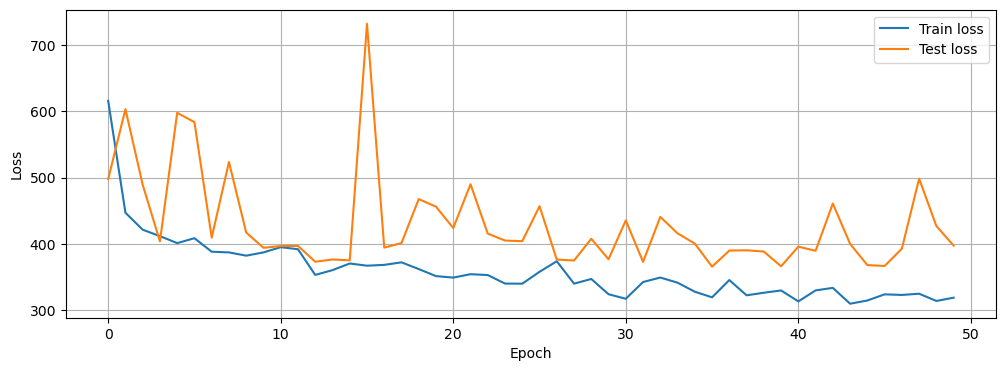

In [63]:
plt.figure(figsize = (12, 4))
plt.plot(epoch_train_loss, label = 'Train loss')
plt.plot(epoch_test_loss, label = 'Test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [64]:
df_pred_targ = pd.DataFrame(columns = ['Best prediction', 'Target'])
for i in range(len(best_pred)):
    df_new = pd.DataFrame({'Best prediction': best_pred[i], 'Target': best_targ[i]})
    df_pred_targ = pd.concat([df_pred_targ, df_new], ignore_index = True)
df_pred_targ['Abs difference'] = abs(df_pred_targ['Best prediction'] - df_pred_targ['Target'])
df_pred_targ['Difference %'] = (df_pred_targ['Abs difference'] / df_pred_targ['Target'])
avg_diff = df_pred_targ['Difference %'].mean()
df_pred_targ['Difference %'] = df_pred_targ['Difference %'].map('{:.2%}'.format)
df_pred_targ

,Best prediction,Target,Abs difference,Difference %
0,2205.810059,2200.0,5.810059,0.26%
1,1482.155029,1350.0,132.155029,9.79%
2,2460.216797,2300.0,160.216797,6.97%
3,2208.420410,2750.0,541.579590,19.69%
4,1713.671143,1480.0,233.671143,15.79%
...,...,...,...,...
291,2492.484375,3100.0,607.515625,19.60%
292,1999.297363,2265.0,265.702637,11.73%
293,2184.489990,2850.0,665.510010,23.35%
294,2664.903076,2750.0,85.096924,3.09%


In [65]:
print(f'Average difference: {avg_diff:.2%}')

Average difference: 16.42%
